# Netflix Shows

In this workbook we'll be anazlying trends between Netflix shows. We have a data set from Kaggle that has a plethora of information such as the actors, the director, the overall rating, what genre it is, and so on. Our goal is to

<u>Base Questions</u>
* Understanding what content is available in different countries
* Understanding how the number of TV shows and Movies on netflix has changed over time

<u>Deeper Questions</u>
* See if we can predict the rating of any particular movie given its details (genre, actors, etc)

>[Import the Data](#Import) <br>
[Initial Investingation](#Inv) <br>
[Question 1](#Q1)<br>
[Question 2](#Q2)<br>
[Question 3](#Q3)

<a id='Import'></a>
## Import the Data

In [1]:
import pandas as pd
import numpy as np
import requests, io
from zipfile import ZipFile

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

> To import the zip file into my directory I used Kaggles API and searched for the dataset using the command line. A quick search (`kaggle datasets list -s netflix`) revealed that the dataset I wanted was stored under `shivamb/netflix-shows`. Thus all I had to do to download the zip file to the directory I wanted was to type `kaggle datasets download shivamb/netflix-shows` to get the zip file downloaded in the directory

In [2]:
# Name of the zip file was found by inspecting the elements in our folder
local_zipfile = "netflix-shows.zip"

# Saving it to a new folder location with the name "netflix-shows"
with ZipFile(local_zipfile, 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(local_zipfile[:-4]) 

> Now we have the data from the zip file extracted and saved in a location called `netflix-shows`. There is one csv file in this folder called `netflix_titles_nov_2019.csv`, let's turn this into a data frame so we can do some initial investigation into the data

In [3]:
df = pd.read_csv('netflix-shows/netflix_titles_nov_2019.csv')
df.head()

,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,type
0,81193313,Chocolate,NaN,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",South Korea,"November 30, 2019",2019,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",Brought together by meaningful meals in the pa...,TV Show
1,81197050,Guatemala: Heart of the Mayan World,"Luis Ara, Ignacio Jaunsolo",Christian Morales,NaN,"November 30, 2019",2019,TV-G,67 min,"Documentaries, International Movies","From Sierra de las Minas to Esquipulas, explor...",Movie
2,81213894,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,"November 30, 2019",2019,TV-14,135 min,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie
3,81082007,Atlantics,Mati Diop,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...","France, Senegal, Belgium","November 29, 2019",2019,TV-14,106 min,"Dramas, Independent Movies, International Movies","Arranged to marry a rich man, young Ada is cru...",Movie
4,80213643,Chip and Potato,NaN,"Abigail Oliver, Andrea Libman, Briana Buckmast...","Canada, United Kingdom",NaN,2019,TV-Y,2 Seasons,Kids' TV,"Lovable pug Chip starts kindergarten, makes ne...",TV Show


<a id ='Inv'></a>
## Initial Investingation

In [4]:
df.shape #relatively small dataset

(5837, 12)

In [5]:
df.info() #Not too much missing info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5837 entries, 0 to 5836
Data columns (total 12 columns):
show_id         5837 non-null int64
title           5837 non-null object
director        3936 non-null object
cast            5281 non-null object
country         5410 non-null object
date_added      5195 non-null object
release_year    5837 non-null int64
rating          5827 non-null object
duration        5837 non-null object
listed_in       5837 non-null object
description     5837 non-null object
type            5837 non-null object
dtypes: int64(2), object(10)
memory usage: 547.3+ KB


In [6]:
df['type'].value_counts()

Movie      3939
TV Show    1898
Name: type, dtype: int64

In [7]:
print('There are ' + str(len(df['country'].value_counts().index.tolist())) + ' countries with netflix shows/movies')

There are 527 countries with netflix shows/movies


<a id='Q1'></a>
## Question 1

What content is available in different countries? (Tv shows vs. movies)
* To answer this let's only look at countries that have more than 5 netflix shows/movies; there were a lot of countries with only 1 put out

In [8]:
# Making a copy to mess around with. Drop irrelevant columns and rows with Null values for the country.
countries_df = df.copy()
column_list = ['title', 'director', 'cast', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']
countries_df = countries_df.drop(column_list, axis = 1)
countries_df = countries_df[countries_df['country'].notnull()]
countries_df.head()

,show_id,country,type
0,81193313,South Korea,TV Show
2,81213894,India,Movie
3,81082007,"France, Senegal, Belgium",Movie
4,80213643,"Canada, United Kingdom",TV Show
5,81172754,Nigeria,Movie


In [9]:
# For entries with multiple countries for a production, we want to give every country credit for this. Lets divide
# up the entries with multiple countries into multiple rows
country_df = pd.DataFrame(countries_df.country.str.split(',').tolist(), index=countries_df.show_id).stack()
country_df = country_df.reset_index([0, 'show_id'])
country_df.head()


# Unfortunately splitting up the string caused issues with white spaces. This next block was designed to deal with
# making " USA" turn into "USA" for example
clean_country_list = []
full_list = countries_df.country.str.split(',').tolist()
for i in full_list:
    for ii in i:
        j = ii.replace(' ',' ')
        clean_country_list.append(j)

# Replacing the country list with 
country_df[0] = clean_country_list
country_df.head()

,show_id,0
0,81193313,South Korea
1,81213894,India
2,81082007,France
3,81082007,Senegal
4,81082007,Belgium


In [10]:
# Now we want to join the movie type to this table. A simple merge will do, drop the extra country column,
# and rename the '0' column to country for more clarity
country_count_df = pd.merge(country_df, countries_df, left_on='show_id', right_on='show_id', how='left').drop('country', axis = 1).rename(columns={0: "country"})
plot_country_df = country_count_df.drop('show_id', axis = 1)
plot_country_df.head(10)

,country,type
0,South Korea,TV Show
1,India,Movie
2,France,Movie
3,Senegal,Movie
4,Belgium,Movie
5,Canada,TV Show
6,United Kingdom,TV Show
7,Nigeria,Movie
8,France,Movie
9,South Africa,Movie


In [11]:
# Now lets only keep countries with at least 10 productions
g = len(plot_country_df.groupby('country').filter(lambda x: len(x) >= 5).country.value_counts().index.tolist())
print('Sadly there are still ' + str(g) + ' countries with over 5 productions so let\'s try 50.\n')

g2 = len(plot_country_df.groupby('country').filter(lambda x: len(x) >= 100).country.value_counts().index.tolist())
print('There are ' + str(g2) + ' countries with 100 productions or more. Let\'s use only these countries')

# Just to compare, lets take the top producing countries and the "middle" producing countries (at least 20 productions)
top_countries = plot_country_df.groupby('country').filter(lambda x: len(x) >= 100).country.value_counts().index.tolist()
middle_countries = plot_country_df.groupby('country').filter(lambda x: len(x) >= 20).country.value_counts().index.tolist()[-10:]


Sadly there are still 85 countries with over 5 productions so let's try 50.

There are 11 countries with 100 productions or more. Let's use only these countries


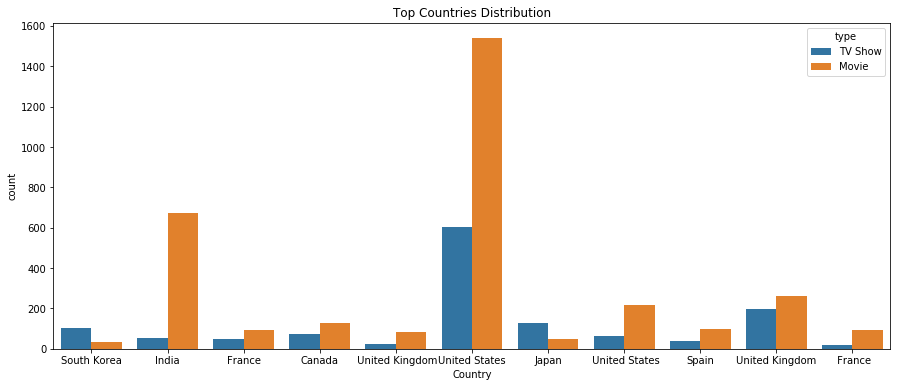

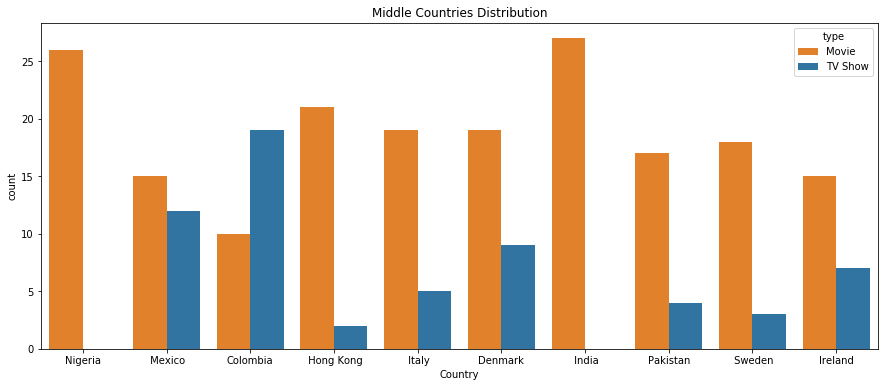

In [12]:
# Now we can make some visuals to see this data
base_color = sb.color_palette()[0]

top_country_count_df = country_count_df[country_count_df['country'].isin(top_countries)]
middle_country_count_df = country_count_df[country_count_df['country'].isin(middle_countries)]

plt.figure(figsize = (15,6))
palette ={"TV Show":"C0","Movie":"C1"}
sb.countplot(data = top_country_count_df, x = 'country', hue = 'type', palette=palette);
plt.xlabel('Country');
plt.title('Top Countries Distribution');
plt.figure(figsize = (15,6))
sb.countplot(data = middle_country_count_df, x = 'country', hue = 'type', palette=palette);
plt.xlabel('Country');
plt.title('Middle Countries Distribution');

> Thus as we can tell, <b> pretty much universally all these countries have more movies than TV shows!</b> That's honestly not what I was expecting considering I mainly use netflix for TV shows. However this categorization does not take into account other categories like for example stand up comedians. I believe that would not necessarily fall into either of these categories and yet they must have been classified in one of the two somehow

<a id='Q2'></a>
## Question 2

Understanding how the number of TV shows and Movies on netflix has changed over time

> In order to do this we can first have to bin the data into time bins and then we can track how the movies/tv prodction has changed over time

In [13]:
# Let's first make a copy of the originial data frame with
date_df = df[df.date_added.isnull() == False]
date_df['date_added'] = pd.to_datetime(date_df.date_added);

date_df['year_added'] = date_df.date_added.dt.year;
drop_list = ['title', 'director', 'cast', 'country', 'release_year', 'duration', 'listed_in', 'description']
date_df = date_df.drop(drop_list,axis = 1)
date_df.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,show_id,date_added,rating,type,year_added
0,81193313,2019-11-30,TV-14,TV Show,2019
1,81197050,2019-11-30,TV-G,Movie,2019
2,81213894,2019-11-30,TV-14,Movie,2019
3,81082007,2019-11-29,TV-14,Movie,2019
5,81172754,2019-11-29,TV-14,Movie,2019



We see that the number of movies released every year has been skyrocketing ahead of the number of TV shows released ever since 2014-2015


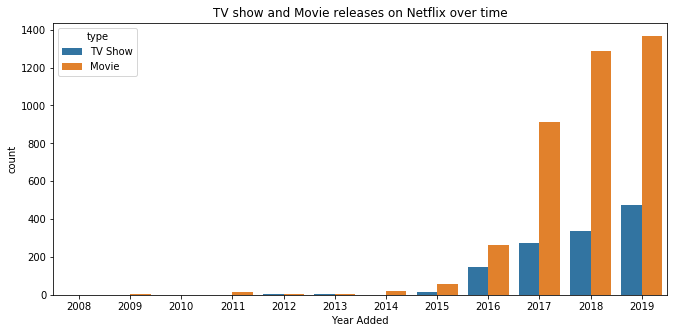

In [14]:
# Now let's first plot how the TV show type has changed over the years, plotting year_added along the x-axis
plt.figure(figsize = (11,5))
sb.countplot(data = date_df, x = 'year_added', hue = 'type');
plt.title('TV show and Movie releases on Netflix over time');
plt.xlabel('Year Added');

print('\nWe see that the number of movies released every year has been skyrocketing ahead of the number of TV shows released ever since 2014-2015')


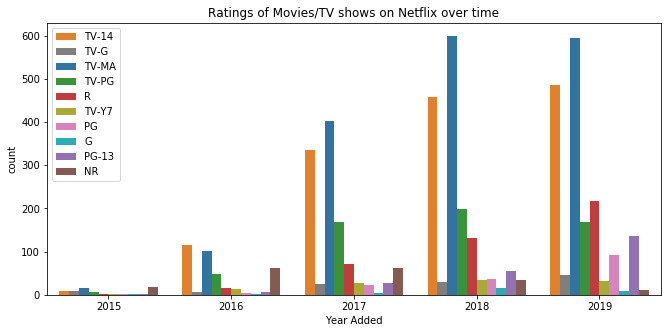

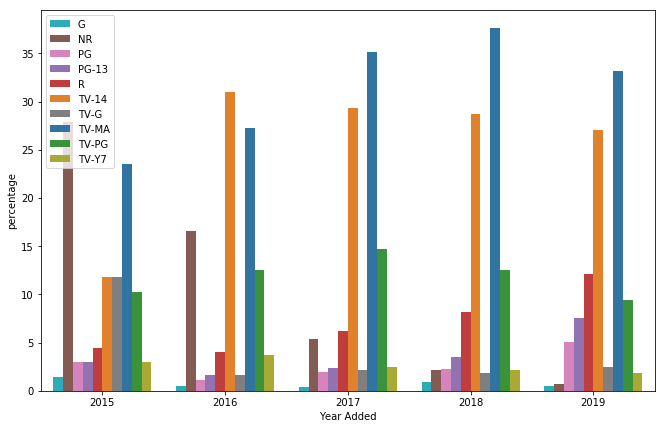

In [15]:
# Now let's look at how the rating of movies has changed over the years

# Only look at years past 2015
onwards2015_df = date_df[date_df['year_added'].isin([2015,2016,2017,2018,2019])]
# Only look at common ratings.
ratings =['TV-MA', 'TV-14','TV-PG','R','PG-13','NR','PG', 'TV-G', 'TV-Y7','G']
onwards2015_df = onwards2015_df[onwards2015_df['rating'].isin(ratings)]

# Used to make sure the palette stays consistent between both plots
palette ={"TV-MA":"C0","TV-14":"C1", "TV-PG":"C2", "R":"C3", "PG-13":"C4", "NR":"C5", "PG":"C6",
         "TV-G":"C7", "TV-Y7":"C8", "G":"C9"}


plt.figure(figsize = (11,5))
sb.countplot(data = onwards2015_df, x = 'year_added', hue = 'rating', palette = palette);
plt.title('Ratings of Movies/TV shows on Netflix over time');
plt.xlabel('Year Added');
plt.legend( loc = 'upper left')

# Let's get this in a percentage format
occupation_counts = (onwards2015_df.groupby(['year_added'])['rating']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('rating'))
plt.figure(figsize = (11,7))
sb.barplot(x = "year_added", y ="percentage", hue="rating", data=occupation_counts, palette = palette)
plt.legend( loc = 'best')
plt.xlabel('Year Added');


> As the second plot shows <b>we've been trending towards a more stable percentage output of ratings for movies and TV shows</b>. The difference between 2017-2019 is negligable with the only significant difference being the percentage of movies with no ratings. The number of movies without ratings (NR) is on a steady downwards trend, as Netflix likely is trying to help out all of its users and add as many details as possible about the porduction as they possibly can to the user.

<a id = 'Q3'></a>
## Question 3

Now let's see if we can recommend similar movies

<b> There are a few things we need to in order to achieve this</b>
* Create a `tokenize` function
>This should be able to take in any string of text, separate the string into a list of words, break each down into the lematized version of the word, remove stop words from the list, and finally make sure that each remaining "word" is in fact a word and not a number

* Creat a `make_recs` function
> This should be able to take in all of the tokenized data and a singular movie id and based off the movie id determine the top movies or shows based off the comminality of the words in their descriptions
    - <u>Input:</u> movie_id, dataset, number of recs to be returned
    - <u>Output:</u> list of recommended movies/shows


In [45]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('abc')


from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /Users/vikram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vikram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vikram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package abc to /Users/vikram/nltk_data...
[nltk_data]   Unzipping corpora/abc.zip.


In [94]:
# Creat tokenizer function
def tokenize(x):
    
    # Generating list of stop words
    stop_words = set(stopwords.words('english'))
    
    # Separate sentance into individual words
    no_punctuation_x = re.sub(r"[^a-zA-Z0-9]"," ", x)
    word_token = word_tokenize(no_punctuation_x)

    # Lemmatizing each word and added cleaned words to clean_words
    lemmatizer = WordNetLemmatizer()
    clean_words = []
    for word in word_token:
        clean_words.append(lemmatizer.lemmatize(word.lower().strip()))

    # Return lematized words that are indeed words and are not in stopwords list
    final_token = [w for w in clean_words if w not in stop_words]
    return final_token

In [95]:
# Testing tokenize function
x = "Dummy example string because tBh I got nothing. I run fAst, super duper very fast. S20 injector beam to BC2."
tokenize(x)

['dummy',
 'example',
 'string',
 'tbh',
 'got',
 'nothing',
 'run',
 'fast',
 'super',
 'duper',
 'fast',
 's20',
 'injector',
 'beam',
 'bc2']

> First way to tackle this problem is using a simple value counts method. Probably not the best but gets our feet off the ground

In [77]:
# Making a copy to mess around with. Drop irrelevant columns and rows with Null values for the country.
nltk_df = df.copy()
column_list = ['date_added', 'release_year', 'rating', 'duration', 'listed_in', 'type']
nltk_df = nltk_df.drop(column_list, axis = 1)
nltk_df.head()

,show_id,title,director,cast,country,description
0,81193313,Chocolate,NaN,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",South Korea,Brought together by meaningful meals in the pa...
1,81197050,Guatemala: Heart of the Mayan World,"Luis Ara, Ignacio Jaunsolo",Christian Morales,NaN,"From Sierra de las Minas to Esquipulas, explor..."
2,81213894,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,A goofy copywriter unwittingly convinces the I...
3,81082007,Atlantics,Mati Diop,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...","France, Senegal, Belgium","Arranged to marry a rich man, young Ada is cru..."
4,80213643,Chip and Potato,NaN,"Abigail Oliver, Andrea Libman, Briana Buckmast...","Canada, United Kingdom","Lovable pug Chip starts kindergarten, makes ne..."


In [78]:
# Initially let's just work with the description column. (Keep title, description, and show_id)
desc_df = nltk_df.copy()
column_list = ['director', 'cast', 'country']
desc_df = desc_df.drop(column_list, axis = 1)
desc_df.head()

,show_id,title,description
0,81193313,Chocolate,Brought together by meaningful meals in the pa...
1,81197050,Guatemala: Heart of the Mayan World,"From Sierra de las Minas to Esquipulas, explor..."
2,81213894,The Zoya Factor,A goofy copywriter unwittingly convinces the I...
3,81082007,Atlantics,"Arranged to marry a rich man, young Ada is cru..."
4,80213643,Chip and Potato,"Lovable pug Chip starts kindergarten, makes ne..."


In [93]:
#tokenize the words in each article title
description_words=[]
tokenized = tokenize(desc_df['description'].str.cat(sep=' '))
description_words.extend(tokenized)
description_words

['brought',
 'together',
 'meaningful',
 'meal',
 'past',
 'present',
 'doctor',
 'chef',
 'reacquainted',
 'begin',
 'working',
 'hospice',
 'ward',
 'sierra',
 'de',
 'la',
 'mina',
 'esquipulas',
 'explore',
 'guatemala',
 'cultural',
 'geological',
 'wealth',
 'including',
 'ancient',
 'mayan',
 'city',
 'natural',
 'wonder',
 'goofy',
 'copywriter',
 'unwittingly',
 'convinces',
 'indian',
 'cricket',
 'team',
 'lucky',
 'mascot',
 'dismay',
 'captain',
 'arranged',
 'marry',
 'rich',
 'man',
 'young',
 'ada',
 'crushed',
 'true',
 'love',
 'go',
 'missing',
 'sea',
 'migration',
 'attempt',
 'miracle',
 'reunites',
 'lovable',
 'pug',
 'chip',
 'start',
 'kindergarten',
 'make',
 'new',
 'friend',
 'try',
 'new',
 'thing',
 'little',
 'help',
 'potato',
 'secret',
 'mouse',
 'pal',
 'nollywood',
 'star',
 'ramsey',
 'nouah',
 'learns',
 'someone',
 'impersonating',
 'break',
 'mental',
 'institution',
 'expose',
 'imposter',
 'romance',
 'mystery',
 'adventure',
 'intertwine',
 '

In [ ]:
# Create make_recs function
# def make_recs()

